# Customer Analytics: Churn Prediction Using Machine Learning
Yosafat Rogika P S (JCDS JKT)

## Context
A telecommunications provider, Telco, is concerned about the number of customers who are switching from their company to competitor. They need to know who is leaving and why they are leaving. We will look at all relevant customer data and provide insights to the marketing department so they may create targeted customer retention strategies.

## Problem Statement :
**Churn** refers to customers or users who leave the services or migrate to a competitor in the industry. It is critical for any corporation to retain present customers while also attracting new ones; if one of them fails, the business suffers. Customer retention is several times less expensive than acquiring new consumers. Furthermore, even a small improvement in client retention raises sales and profits dramatically. 

## Goals :
As a result, the company wants to be able to predict whether or not a customer will / wants to leave the company. understanding which customers are more likely to switch to competitors and what variables contribute to this is critical for Telco. The company will be able to optimize its customer retention campaigns using this data.

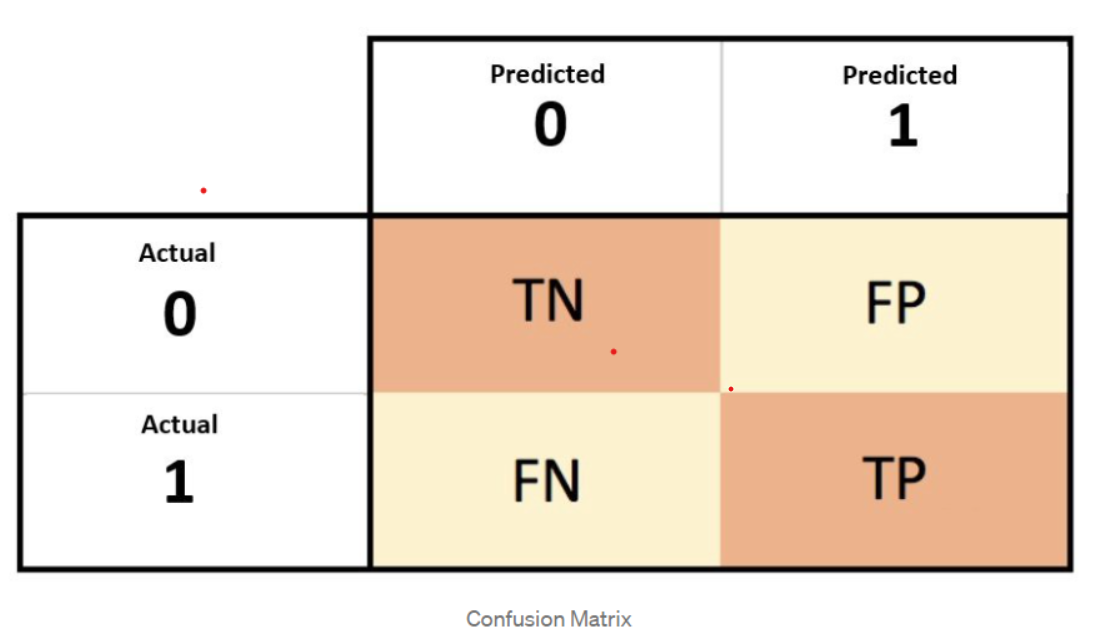

Type 1 error : **False Positive**  
**consequence** : wasted retention costs, time and resources.

Type 2 error : **False Negative**  
**consequence** : lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, etc.

Given the consequences, what we will do as much as possible is build a model that reduces customer loss because it costs much less to retain an existing customer than it is to acquire a new customer, maintaining a healthy customer base is critical. for the success of any business.

So we will focus on the FN value, by obtaining a high recall value. But we also don't want to ignore the results of small precision. Therefore, we need to balance the recall value and its precision. So the main metric that we will use is the f1-score for the model whose data is still imbalanced, and when we do oversampling (SMOTE) we will use the default(accuracy)&/ roc_auc metric. Where the results of the two will be compared to get the most optimal model for this case.

****

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, ShuffleSplit, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('data_telco_customer_churn.csv')
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


## Attributes Information
There are **4930 rows** of data in this dataset, with **11** columns containing information about customer data that uses telecommunications services.
### Prediction column:
1. `Churn`: Whether the customer churned or not (Yes or No)
### Two numerical columns:
2. `Tenure`: Number of months the customer has stayed with the company
3. `MonthlyCharges`: The amount charged to the customer monthly
### Eight categorical columns:
4. `Dependents`: Whether the customer has dependents or not (Yes, No)
5. `OnlineSecurity`: Whether the customer has online security or not (Yes, No, No internet service)
6. `OnlineBackup`: Whether the customer has an online backup or not (Yes, No, No internet service)
7. `InternetService`: Customer’s internet service provider (DSL, Fiber optic, No)
8. `DeviceProtection`: Whether the customer has device protection or not (Yes, No, No internet service)
9. `TechSupport`: Whether the customer has tech support or not (Yes, No, No internet service)
10. `Contract`: The contract term of the customer (Month-to-month, One year, Two years)
11. `PaperlessBilling`: Whether the customer has paperless billing or not (Yes, No)

## The project is structured as follows:
1. **Data Wrangling**
2. **Exploratory Data Analysis**
3. **Data Preprocessing**
4. **Encoding**
5. **Feature Selection**
6. **Base Model Creation and Evaluation**
7. **Oversampling Technique -> New Base Model**
8. **Evaluation Matrix**
7. **Improving the Model:**
    - **Hyperparameter Tuning using GridSearchCV** 
9. **Evaluation Improved Model**

## Data Wrangling

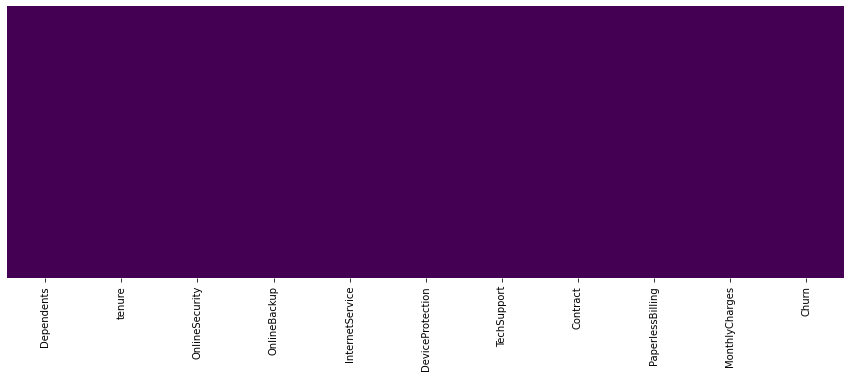

In [4]:
# Checking Missing Value
plt.figure(figsize = (15, 5))
sns.heatmap(df.isna(), cmap = 'viridis',yticklabels = False, cbar= False)
plt.show()

In [5]:
# General data info
listItem = []
for col in df.columns :
    listItem.append([col,
                     df[col].dtype,
                     len(df),
                     df[col].isna().sum(),
                     round((df[col].isna().sum()/len(df[col])) * 100,2),
                     df[col].nunique(), 
                     df[col].unique()])

dfDesc = pd.DataFrame(columns=['Column Name', 
                               'Data Type', 
                               'Data Count', 
                               'Missing Value', 
                               'Missing Value Percentage', 
                               'Number of Unique', 
                               'Unique'],
                     data=listItem)
dfDesc

,Column Name,Data Type,Data Count,Missing Value,Missing Value Percentage,Number of Unique,Unique
0,Dependents,object,4930,0,0.0,2,"[Yes, No]"
1,tenure,int64,4930,0,0.0,73,"[9, 14, 64, 72, 3, 40, 17, 11, 8, 47, 18, 5, 1..."
2,OnlineSecurity,object,4930,0,0.0,3,"[No, Yes, No internet service]"
3,OnlineBackup,object,4930,0,0.0,3,"[No, Yes, No internet service]"
4,InternetService,object,4930,0,0.0,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,object,4930,0,0.0,3,"[Yes, No internet service, No]"
6,TechSupport,object,4930,0,0.0,3,"[Yes, No, No internet service]"
7,Contract,object,4930,0,0.0,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,object,4930,0,0.0,2,"[Yes, No]"
9,MonthlyCharges,float64,4930,0,0.0,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7,..."


It can be seen that each column has no missing values. Each column also has more than one value type which means each column can be used in classification.

## Exploratory Data Analysis

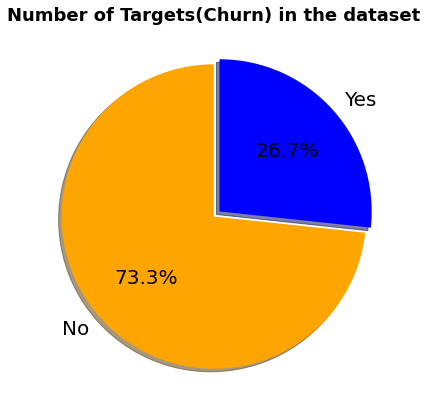

In [6]:
plt.figure(figsize=(7,7))
plt.title("Number of Targets(Churn) in the dataset", size=18, weight='bold')
plt.pie(df['Churn'].value_counts(), explode=(0,0.05), labels=['No', 'Yes'], colors=["orange","blue"], autopct='%1.1f%%', shadow=True, 
        startangle=90, textprops={"fontsize":20})

plt.show()

## Target variable
We are trying to predict if the user left the company in the previous month. Therefore we have a binary classification problem with a slightly unbalanced target:
- Churn: No -> 73.3%
- Churn: Yes -> 26.7%

### Numerical Features
There are only two numerical columns: `tenure` and `MonthlyCharges`.

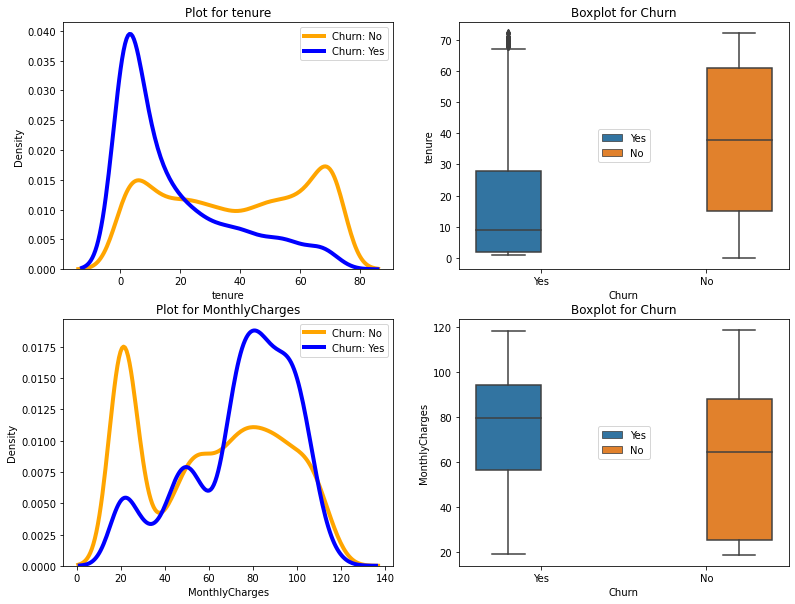

In [7]:
plt.figure(figsize=(13, 10))
def plotting(target, feature, hist, kde, subplot):
    plt.subplot(subplot)
    plt.title("Plot for {}".format(feature))
    sns.distplot(df[df[target] == 'No'][feature], hist=hist, kde=kde, 
                 color = 'orange',  
                 label= target + ': No',
                 kde_kws={'linewidth': 4})
    sns.distplot(df[df[target] == 'Yes'][feature], hist=hist, kde=kde, 
                 color = 'blue',  
                 label= target + ': Yes',
                 kde_kws={'linewidth': 4})
    plt.legend()
    plt.subplot(subplot+1)
    plt.title("Boxplot for {}".format(col))
    sns.boxplot(data = df,y = feature, x = target, hue = target)
    plt.legend(loc='center')

plotting(target = 'Churn', feature = 'tenure', hist = False, kde = True, subplot = 221)

plotting(target = 'Churn', feature = 'MonthlyCharges', hist = False, kde = True, subplot = 223)

plt.show()

#### From the plot and boxplot above, it can be concluded:
1. New users (low `tenure`) are more likely to churn
2. Users with higher `MonthlyCharges` are also more likely to churn

### Categorical features
This dataset has 8 categorical features :
- Two binary features (Yes/No) -> `Dependents` & `PaperlessBilling`
- Six features with three unique values -> `OnlineSecurity`, `OnlineBackup`, `InternetService`, `DeviceProtection`, `TechSupport`, and `Contract`

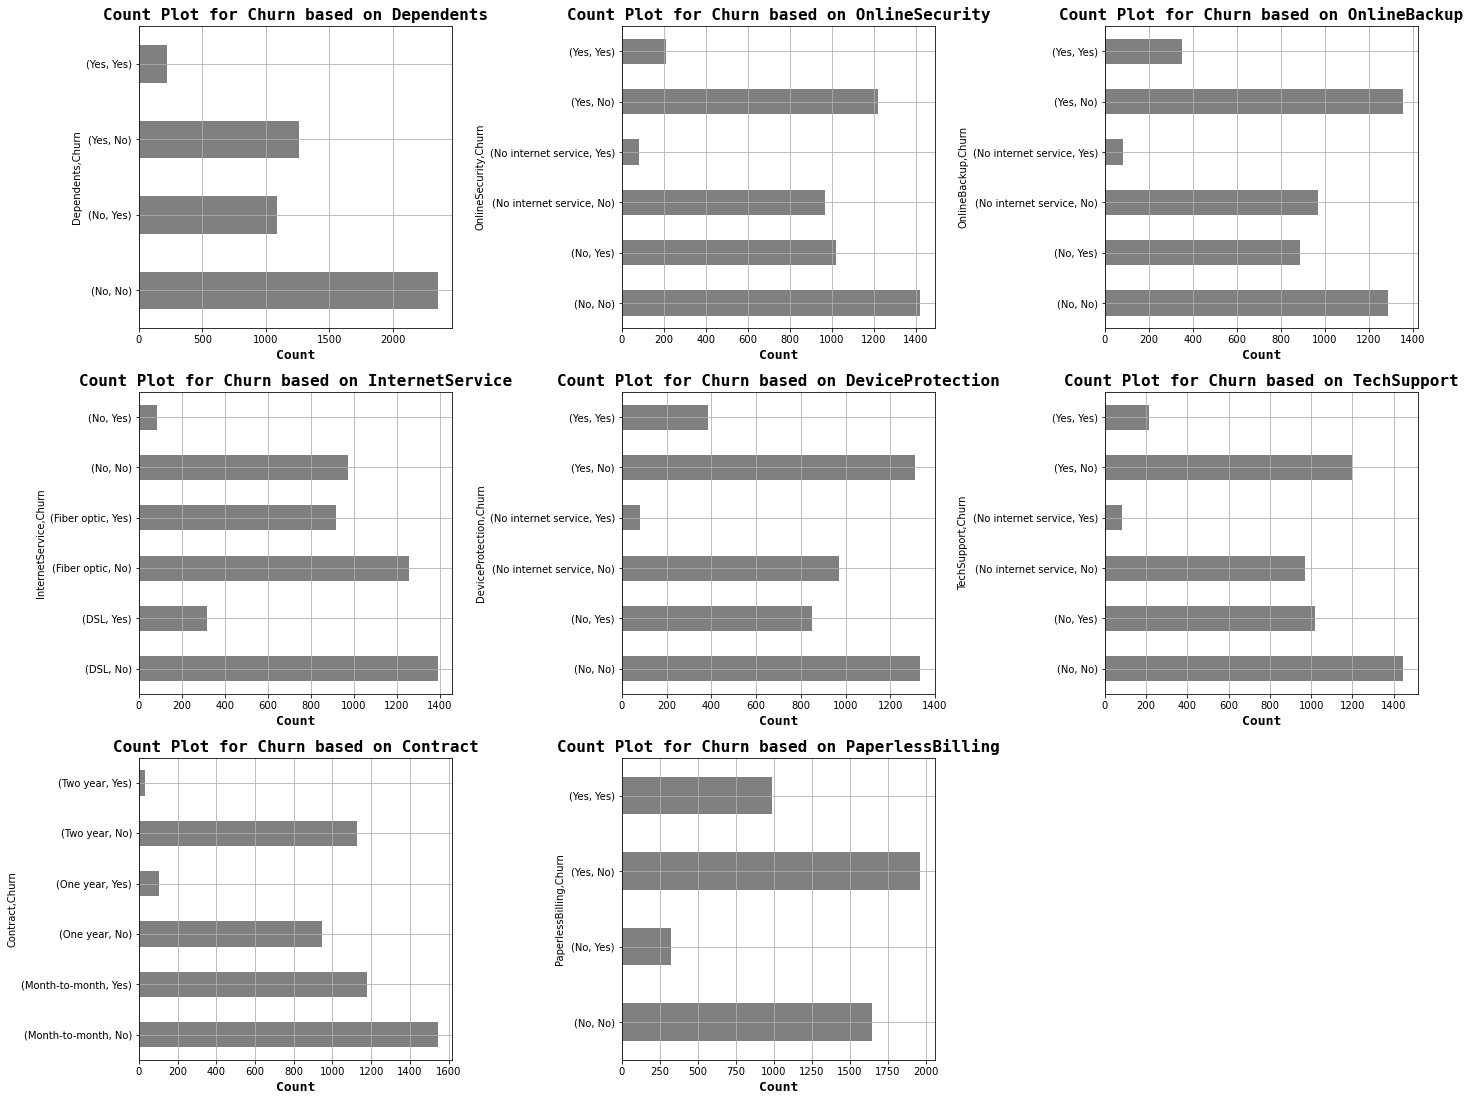

In [8]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['tenure','MonthlyCharges','Churn']).columns:
    count +=1
    ax= plt.subplot(4,3,count)
    plt.title('Count Plot for Churn based on {}'.format(i), size=16, fontweight='bold', fontfamily='monospace')
    df.groupby(df[i])['Churn'].value_counts().plot(kind='barh', color='grey', ax=ax) 
    plt.xlabel('Count',size=13, fontweight='bold', fontfamily='monospace')
    plt.grid(True)
    fig.tight_layout()
    
plt.show()

Based on the Barplot above, it can be concluded:
1. Customers **without** `Dependents` 4 times more frequently left the Telco company, than customers with `Dependents`.
2. Customers **without** (`OnlineSecurity` = No) 5 times more frequently left the Telco company, than customers with (`OnlineSecurity` = Yes).
3. Customers **without** (`OnlineBackup` = No) 3 times more frequently left the Telco company, than customers with (`OnlineBackup` = Yes).
4. Customers with **Fiber optic** `Internetservice` 2.2 times more frequently left the Telco company, than customers with DSL.
5. Customers **without** (`DeviceProtection` = No) 2 times more frequently left the Telco company, than customers with (`DeviceProtection` = Yes).
6. Customers **without** (`TechSupport` = No) 5 times more frequently left the Telco company, than customers with (`TechSupport` = Yes).
7. Customers with **month-to-month** `Contract` type 6.3 times more frequently left the Telco company, than customers with one-year and two-year `Contract` type.
8. Customers **without** `PaperlessBilling` are 4 times more frequently left the Telco company, than clients with paper billing.



From all the variables that have been described, it can be concluded that all variables are significant for use in the modeling process.

## Data Preparation

In [9]:
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


Now we will change the data type on the target `Churn` which is still an object to be an integer

- Yes -> 1
- No -> 0

Then the `Contract` feature will be changed in ordinal form using OrdinalEncoder, and columns with other object data types will be changed using OneHotEncoder.

In [10]:
# Changing Target values
df['Churn'] = df['Churn'].map({'Yes' : 1, 'No' : 0})

In [11]:
# Assign Independent and Dependent Variable
X = df.drop(columns = 'Churn')
y = df['Churn']

In [12]:
# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size = .80, random_state=42)

In [13]:
ohe_col = ['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService', 'DeviceProtection', 'TechSupport', 'PaperlessBilling'] 
ord_col = ['Contract']
ord_map = [{'col' : 'Contract', 
            'mapping' :{'Month-to-month' : 0, 
                        'One year' : 1,
                        'Two year' : 2
                       }
           }]

preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ohe_col ),
    ('ordinal', ce.OrdinalEncoder(mapping= ord_map), ord_col)
], remainder='passthrough')

base_LogReg = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression())
])

base_KNN = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

base_DT = Pipeline([
    ('prep', preprocessor),
    ('algo', DecisionTreeClassifier())
])

base_RF = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier())
])

base_XGB = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier())
])

Furthermore, the ability of the base model will be sorted based on its F1 score because the dataset is imbalanced.

In [14]:
base_model= [base_LogReg, base_KNN, base_DT, base_RF, base_XGB]
model = ['LogReg', 'KNN', 'DT', 'RF', 'XGB']
data = {}

def Eva_Matrix(Model, X, y_true):
    y_pred = Model.predict(X)
    Acc = accuracy_score(y_true, y_pred)
    Rec = recall_score(y_true, y_pred)
    Prec = precision_score(y_true, y_pred)
    F1 = f1_score(y_true, y_pred)
    y_predict_proba = Model.predict_proba(X)[:,1]
    roc_auc = roc_auc_score(y_true, y_predict_proba)
    return Acc, Rec, Prec, F1, roc_auc

for i in range(len(base_model)):
    base_model[i].fit(X_train, y_train)
    Acc_train, Rec_train, Prec_train, F1_train, roc_auc_train = Eva_Matrix(base_model[i], X_train, y_train)
    Acc_test, Rec_test, Prec_test, F1_test, roc_auc_test = Eva_Matrix(base_model[i], X_test, y_test)
    data[f'Train {model[i]}'] = Acc_train, Rec_train, Prec_train, F1_train, roc_auc_train
    data[f'Test {model[i]}'] = Acc_test, Rec_test, Prec_test, F1_test, roc_auc_test
pd.DataFrame(data = data, index = ["Accuracy", "Recall", "Precision", "F1", "roc_auc"]).T.sort_values('F1', ascending=False)

,Accuracy,Recall,Precision,F1,roc_auc
Train RF,0.992647,0.979107,0.993256,0.986131,0.999599
Train DT,0.992647,0.973409,0.999025,0.986051,0.999851
Train XGB,0.921653,0.819563,0.878819,0.848157,0.977187
Train KNN,0.835700,0.626781,0.721311,0.670732,0.896872
Test LogReg,0.796146,0.558935,0.633621,0.593939,0.856623
Test XGB,0.788032,0.570342,0.609756,0.589391,0.841566
Train LogReg,0.794878,0.526116,0.641204,0.577986,0.840539
Test RF,0.782961,0.482890,0.619512,0.542735,0.822016
Test KNN,0.766734,0.513308,0.569620,0.540000,0.778592
Test DT,0.732252,0.475285,0.498008,0.486381,0.658844


It can be seen that the results of some training models are very high compared to the data testing, this happens because the model is too follow the pattern of the data train (Overfitting). The low f1 results on data testing indicate that the base model is not good enough in predicting the target. In this case, the Logistic Regression base model has the highest f1 score. for the next oversampling technique will be carried out using SMOTE.

In [15]:
sm = SMOTE(random_state=42)

In [16]:
X_train = pd.DataFrame(preprocessor.fit_transform(X_train),columns=preprocessor.get_feature_names())
X_test = pd.DataFrame(preprocessor.transform(X_test),columns=preprocessor.get_feature_names())

In [17]:
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [18]:
df_SMOTE = pd.concat([X_train_sm, y_train_sm], axis=1)

In [19]:
df_SMOTE['Churn'].value_counts()

0    2891
1    2891
Name: Churn, dtype: int64

In [20]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()

In [21]:
models= [logreg, knn, dt, rf, xgb]
model = ['LogReg', 'KNN', 'DT', 'RF', 'XGB']
data = {}

for i in range(len(models)):
    models[i].fit(X_train_sm, y_train_sm)
    Acc_train, Rec_train, Prec_train, F1_train, roc_auc_train = Eva_Matrix(models[i], X_train_sm, y_train_sm)
    Acc_test, Rec_test, Prec_test, F1_test, roc_auc_test = Eva_Matrix(models[i], X_test, y_test)
    data[f'Train {model[i]}'] = Acc_train, Rec_train, Prec_train, F1_train, roc_auc_train
    data[f'Test {model[i]}'] = Acc_test, Rec_test, Prec_test, F1_test, roc_auc_test
pd.DataFrame(data = data, index = ["Accuracy", "Recall", "Precision", "F1", "roc_auc"]).T.sort_values('Accuracy', ascending=False)

,Accuracy,Recall,Precision,F1,roc_auc
Train DT,0.994639,0.989623,0.999651,0.994612,0.999940
Train RF,0.994466,0.994811,0.994124,0.994467,0.999864
Train XGB,0.936181,0.942580,0.930669,0.936587,0.986693
Train KNN,0.856451,0.939467,0.805696,0.867454,0.950664
Test XGB,0.795132,0.661597,0.606272,0.632727,0.842308
Test RF,0.778905,0.513308,0.600000,0.553279,0.818716
Train LogReg,0.760809,0.796610,0.743383,0.769077,0.840962
Test LogReg,0.744422,0.809886,0.513253,0.628319,0.855140
Test DT,0.730223,0.501901,0.494382,0.498113,0.664631
Test KNN,0.710953,0.695817,0.471649,0.562212,0.761321


With the model for the oversampled data, we find two better candidate models for the LogisticRegression and XGBoosting models. Of course, both will be compared with the confusion matrix to choose a model that will later be optimized with hyperparameter tuning.

In [22]:
# Logistic Regression
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81       723
           1       0.51      0.81      0.63       263

    accuracy                           0.74       986
   macro avg       0.71      0.77      0.72       986
weighted avg       0.81      0.74      0.76       986



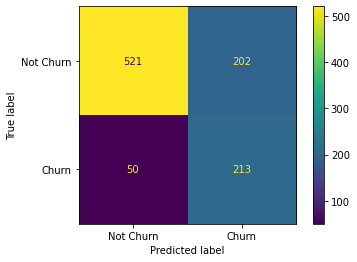

In [23]:
plot_confusion_matrix(logreg, X_test, y_test, display_labels=['Not Churn', 'Churn'])

The logistic regression model is able to predict 81% of all customers who should churn. but the model only has a precision of 51%, which means that the prediction model is only right for 51% of customers whose prediction model will churn. (Based on Recall)

In [24]:
# XGBoosting
print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       723
           1       0.61      0.66      0.63       263

    accuracy                           0.80       986
   macro avg       0.74      0.75      0.75       986
weighted avg       0.80      0.80      0.80       986



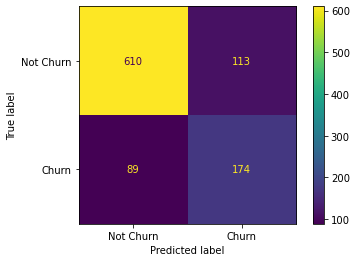

In [25]:
plot_confusion_matrix(xgb, X_test, y_test, display_labels=['Not Churn', 'Churn'])

The XGBoosting model is able to predict 66% of all customers who should churn. but the model only has a precision of 61%, which means that the prediction model is only right for 61% of customers whose prediction model will churn. (Based on Recall)

The two base models with feature engineering that have been carried out have advantages and disadvantages that can be seen from the confusion matrix. Where XGBoosting has more 'diplomatic' results than logistic regression, so we need to optimize both models with hyperparameter tuning for each model.

In [26]:
# Random Forest
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       723
           1       0.60      0.51      0.55       263

    accuracy                           0.78       986
   macro avg       0.72      0.69      0.70       986
weighted avg       0.77      0.78      0.77       986



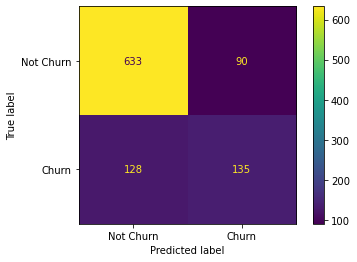

In [27]:
plot_confusion_matrix(rf, X_test, y_test, display_labels=['Not Churn', 'Churn'])

## Hyperparameter Tuning

In [28]:
param_LR = {
    'C' : np.logspace(-3, 3, 7),
    'penalty' : ['l1', 'l2', 'elasticnet']

}
skf = StratifiedKFold(n_splits=4)

In [29]:
GS_logreg = GridSearchCV(logreg, param_LR, cv = skf, n_jobs=-1, verbose = True)

In [30]:
GS_logreg.fit(X_train_sm, y_train_sm)

Fitting 4 folds for each of 21 candidates, totalling 84 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             verbose=True)

In [31]:
GS_logreg.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [32]:
LR_Tuned = GS_logreg.best_estimator_

In [33]:
print(classification_report(y_test, LR_Tuned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81       723
           1       0.52      0.81      0.63       263

    accuracy                           0.75       986
   macro avg       0.72      0.77      0.72       986
weighted avg       0.81      0.75      0.76       986



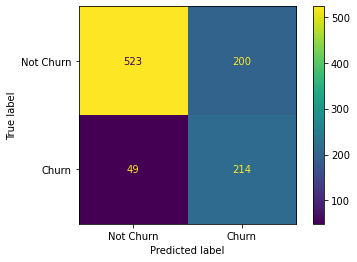

In [34]:
plot_confusion_matrix(LR_Tuned, X_test, y_test, display_labels=['Not Churn', 'Churn'])

The logistic regression model is able to predict 81% of all customers who should churn. but the model only has a precision of 52%, which means that the prediction model is only right for 52% of customers whose prediction model will churn.(Based on Recall). Slightly better than without tuning.

Now we check the tuned XGBoosting model.

In [33]:
param_XGB = {
    "n_estimators" : np.arange(100, 401, 100),
    "max_depth" : np.arange(1, 6),
    "learning_rate" : np.logspace(-3, 0, 4),
    "gamma" : np.logspace(-3, 0, 6),
    "colsample_bytree" : [0.3, 0.5, 0.7, 0.8],
    "subsample" : [0.3, 0.5, 0.7, 0.8],
    "reg_alpha" : np.logspace(-3, 3, 7),
    "reg_lambda" : np.logspace(-3, 3, 7)
}

In [34]:
GS_XGB = GridSearchCV(xgb, param_XGB, cv = skf, verbose = 3, n_jobs=-1)

In [35]:
GS_XGB.fit(X_train_sm, y_train_sm)

Fitting 4 folds for each of 376320 candidates, totalling 1505280 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_c...
                         'gamma': array([0.001     , 0.00398107, 0.01584893, 0.06309573, 0.25118864,
       1.        ]),
                         'learning_rate': array([0.001, 0.01 , 0.1  , 1.   ]),
                         'max_depth': array([1, 2, 3, 4, 5]),
                         'n_estimators': array([100, 200, 

In [36]:
GS_XGB.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.003981071705534973,
 'learning_rate': 1.0,
 'max_depth': 5,
 'n_estimators': 400,
 'reg_alpha': 1.0,
 'reg_lambda': 100.0,
 'subsample': 0.3}

In [37]:
XGB_Tuned = GS_XGB.best_estimator_

In [38]:
print(classification_report(y_test, XGB_Tuned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       723
           1       0.62      0.67      0.64       263

    accuracy                           0.80       986
   macro avg       0.75      0.76      0.75       986
weighted avg       0.81      0.80      0.80       986



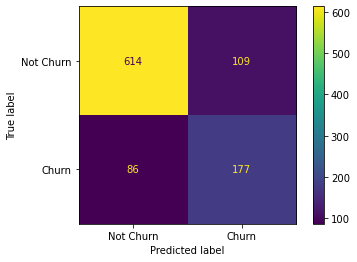

In [39]:
plot_confusion_matrix(XGB_Tuned, X_test, y_test, display_labels=['Not Churn', 'Churn'])

The XGBoosting model is able to predict 67% of all customers who should churn. but the model only has a precision of 62%, which means that the prediction model is only right for 62% of customers whose prediction model will churn. (Based on Recall). Slightly better than the XGBoosting model without tuning.

In [35]:
fine_param_XGB = {
    "n_estimators" : [400, 601, 50],
    "max_depth" : [5,10,1],
    "learning_rate" : [1.0],
    "gamma" : [0.00398107],
    "colsample_bytree" : [0.1, 0.2, 0.3],
    "subsample" : [0.1, 0.2, 0.3],
    "reg_alpha" : [1],
    "reg_lambda" : [100]
}

In [36]:
fine_GS_XGB = GridSearchCV(xgb, fine_param_XGB, cv = skf, verbose = 3, n_jobs=-1)

In [37]:
fine_GS_XGB.fit(X_train_sm, y_train_sm)

Fitting 4 folds for each of 81 candidates, totalling 324 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_c...
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1, ...),
             n_jobs=-1,
      

In [38]:
fine_GS_XGB.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.00398107,
 'learning_rate': 1.0,
 'max_depth': 5,
 'n_estimators': 400,
 'reg_alpha': 1,
 'reg_lambda': 100,
 'subsample': 0.3}

In [39]:
XGB_fine_Tuned = fine_GS_XGB.best_estimator_

In [40]:
print(classification_report(y_test, XGB_fine_Tuned.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       723
           1       0.62      0.67      0.64       263

    accuracy                           0.80       986
   macro avg       0.75      0.76      0.75       986
weighted avg       0.81      0.80      0.80       986



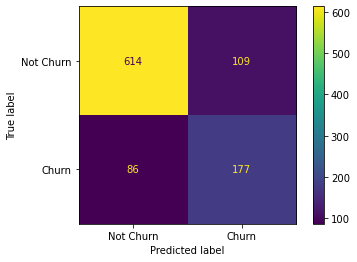

In [42]:
plot_confusion_matrix(XGB_fine_Tuned, X_test, y_test, display_labels=['Not Churn', 'Churn'])

After fine tuning the XGboost model, the results are still the same, 67% recall and 62% precision.

# Model & Cost Evaluation
To evaluate the model that we have determined (Logistic Regression, Extreme Gradient Boosting Tuned, Extreme Gradient Boosting (Recall) after Tuned), we will create a scenario as follows:

We assume the cost of acquiring new customers is up to **5 times higher** than the cost of retaining them. 

So, I made the following cost assumptions to explore the cost implications of implementing the model.
- I assigned the **true negatives the cost 0 cost**. 
- False negatives were the most damaging, as they predicted falsely that a churning consumer would stay. I will lose the customer and will be responsible for any costs associated with finding a replacement, including lost revenue, advertising costs, administrative fees, and so on. **I will assume 5 * cost. This is the cost of false negatives.**
- Finally, for customers that my model identifies as churning (True Positives & False Positives), **I will assume 1 * cost(TP & FP)**

So, we will have an equation to describe the cost. Our goals is to minimize the cost :

\begin{equation}
Cost(c) = 5*(c)*FN + 1*(c)*(TP + FP) + 0*(c)*TN 
\end{equation}

## RESULT :

1. **Worst Case Scenario**
The company does not apply any model to predict customer churn and assume that no customer will churn. But in reality 263 customers ended up churning. so the cost will be **5 * 263(c) = 1315 (c).**

2. **Focussing Retention Strategies on all Customers**
The company doesn’t apply any predictive model and decides to focus retention efforts on all customers.
so the cost will be **1 * 986(c) = 986 (c).**

3. **Best Case Scenario**
The company has a predictive model that correctly predicts who all will churn and to maintain the customer base.
so the cost will be **1 * 263(c) = 263 (c).**

4. **Current Predictive Model**
    - **Logistic Regression Tuned** : 5*(49)(c) + 1*(414)(c) = **659 (c)**    
    - **XGBoosting Fine Tuned** : 5*(86)(c) + 1*(286)(c) = **716 (c)**

In [43]:
data = {'no model' : [1315],
        'voucher to all customer' : [986],
        'ideal model' : [263],
        'Logistic Regression Tuned' : [659],
        'XGBoosting Fine Tuned' : [716],
       }
dfcost = pd.DataFrame(data=data, index=['Cost Amplification'])
cost = dfcost.T.sort_values('Cost Amplification', ascending=False)

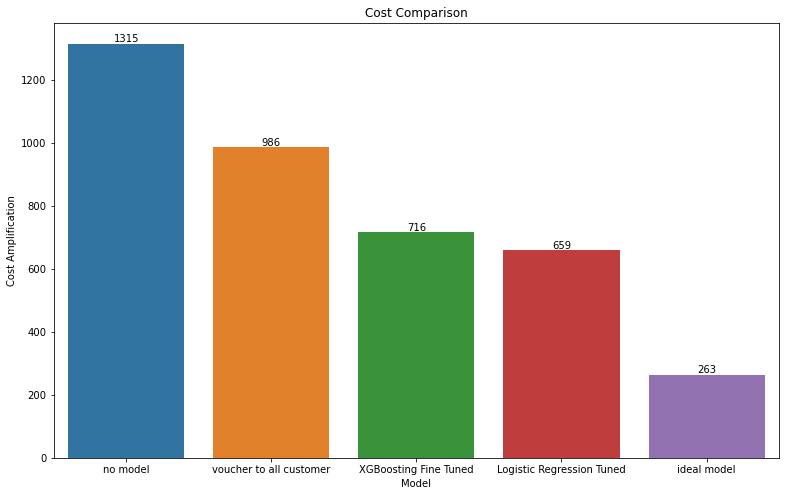

In [44]:
plt.figure(figsize=(13,8))
ax = sns.barplot(cost.index,cost['Cost Amplification'])
plt.title('Cost Comparison')
plt.xlabel('Model')
ax.bar_label(ax.containers[0])
plt.show()

From the barplot above we can see that by using the Logistic Regression Tuned Model we can reduce the amount of costs incurred:
- around 50% reduction from worstcase(no model) and 
- around 33% reduction from focus on customer retention (vouchers to all customers).

This means that with this model, Telco companies can **save about 50% of their total expenses.**

# Conclusion & Recommendation
- Conclusion:
    1. From the analysis that has been described, the appropriate model for this case is **Logistic Regression** which has been performed with **hyperparameter tuning.**
    2. The best Hyperparameter values are as follows: 
        **{'C': 0.1, 
        'penalty': 'l2'}**
    3. **Recall** and **Precision** values respectively (based on the recall class(+)) are **81%** and **52%**.
    4. For the scenarios that have been made, the model is **able to save costs up to 50% of the total cost** if the model is not implemented.
    

- Recommendation:
    1. The implementation of the Model is limited to cases when the resulting cost for customer churn is approximately 5 times greater than the retention cost. Outside of this case the confidence of the model used will be different (low p-value), because the ability of the model will depend on the evaluation matrix that will be used in the cost formula.
    2. Adding features in feature selection such as the payment method used, streaming services, or other matters related to the telecommunication service domain.
    3. Try a combination of feature engineering and modelling other Machine Learning algorithms.
    4. Conduct a more in-depth data analysis for data that was mispredicted by the model (FP & TP) in order to know its characteristics. 
    

**Thankyou!!!**
